<a href="https://colab.research.google.com/github/ulissigroup/Enabling-Robust-Offline-Active-Learning-for-MLPs/blob/master/Final_Code_NEB_FOR_PAPER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Installation of packages

In [2]:
!pip install -q git+https://github.com/saurabhsivakumar/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

     |████████████████████████████████| 296kB 6.9MB/s 
     |████████████████████████████████| 6.7MB 13.8MB/s 
     |████████████████████████████████| 102kB 9.7MB/s 
     |████████████████████████████████| 2.2MB 40.3MB/s 
     |████████████████████████████████| 12.8MB 236kB/s 
     |████████████████████████████████| 110.5MB 37kB/s 
     |████████████████████████████████| 512kB 40.3MB/s 
     |████████████████████████████████| 3.8MB 35.1MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatib

#### Build the NEBcalculator class, construct geometry and train with the active learner

In [1]:
! nvidia-smi

Thu Sep 24 13:11:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import copy
import os
import numpy as np
import random

import torch

from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty
from amptorch.active_learning.al_utils import CounterCalc, attach_sp_calc
from amptorch.model import CustomMSELoss

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.optimize import QuasiNewton
from ase.neb import NEB, SingleCalculatorNEB
from ase.optimize import BFGS, FIRE, BFGSLineSearch
from ase import Atoms, Atom, units
from ase.build import molecule
from ase.visualize import view
from ase.io import read, write
from ase.io.trajectory import TrajectoryReader,Trajectory
from ase.build import fcc100, add_adsorbate,bcc100,fcc111
from ase.constraints import FixAtoms
from ase.neb import NEBTools

import dftbook
dftbook.setup_colab()
from espresso import Espresso

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 


Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 26.9 seconds


**Important Note**: The QE colab calculator only works with some GPUs provided by the standard free colab. Here colab pro with Tesla P100-PCIE GPU was used.

In [4]:
class NEBcalc:
    def __init__(self, starting_images, ml2relax=True, intermediate_samples=3):
      """
      Computes a NEB given an initial and final image.

      Parameters
      ----------
      starting_images: list. Initial and final images to be used for the NEB.

      ml2relax: boolean. True to use ML to relax the initial and final structure guesses. 
      False if initial and final structures were relaxed beforehand.
      
      intermediate_samples: int. Number of intermediate samples to be used in constructing the NEB"""
      
      self.starting_images = copy.deepcopy(starting_images)
      self.ml2relax = ml2relax
      self.intermediate_samples = intermediate_samples
      
    def run(self, calc, filename):
      """
      Runs NEB calculations.
      Parameters
      ----------
      calc: object. Calculator to be used to run method.
      filename: str. Label to save generated trajectory files."""
      
      initial = self.starting_images[0].copy()
      final = self.starting_images[-1].copy()
      if self.ml2relax:
        # Relax initial and final images
        ml_initial = initial
        ml_initial.set_calculator(calc)
        ml_final = final
        ml_final.set_calculator(calc)
        print('BUILDING INITIAL')
        qn = BFGS(ml_initial, trajectory='initial.traj', logfile='initial_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        print('BUILDING FINAL')
        qn = BFGS(ml_final, trajectory='final.traj', logfile='final_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        initial = ml_initial.copy()
        final = ml_final.copy()

      initial.set_calculator(calc)
      final.set_calculator(calc)

      images = [initial]
      for i in range(self.intermediate_samples):
        image = initial.copy()
        image.set_calculator(calc) 
        images.append(image)
      images.append(final)

      print('NEB BEING BUILT')
      neb = SingleCalculatorNEB(images)
      neb.interpolate()
      print('NEB BEING OPTIMISED')
      opti = BFGS(neb, trajectory=filename+".traj", logfile='al_neb_log.txt')
      opti.run(fmax=0.01, steps=100)
      print('NEB DONE')

      """ 
      The following code is used to visualise the NEB at every iteration 
      """
      
      built_neb = NEBTools(images)
      barrier, dE = built_neb.get_barrier()
      max_force = built_neb.get_fmax()
      fig = built_neb.plot_band()
      plt.show()
      
    def get_trajectory(self, filename):
      trajectory = Trajectory(filename + ".traj")
      atom_list = []
      for atom in trajectory:
        atom_list.append(atom)
      return atom_list

In [5]:
#https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial
#Surface Diffusion Energy Barriers
#Building your structure

def construct_geometries(parent_calc, ml2relax):
  counter_calc = CounterCalc(parent_calc,"parent_database")
  # Initial structure guess
  initial_slab = fcc100('Cu', size=(2, 2, 3))
  add_adsorbate(initial_slab, 'O', 1.7, 'hollow')
  initial_slab.center(axis=2, vacuum=4.0)
  mask = [atom.tag > 1 for atom in initial_slab]
  initial_slab.set_constraint(FixAtoms(mask=mask))

  initial_slab.set_calculator(counter_calc)

  # Final structure guess
  final_slab = initial_slab.copy()
  final_slab[-1].x += final_slab.get_cell()[0, 0] / 3
  final_slab.set_calculator(counter_calc)

  if not ml2relax:
    print('BUILDING INITIAL')
    qn = BFGS(initial_slab, trajectory='initial.traj', logfile='initial_relax_log.txt')
    qn.run(fmax=0.01, steps=100)
    print('BUILDING FINAL')
    qn = BFGS(final_slab, trajectory='final.traj', logfile='final_relax_log.txt')
    qn.run(fmax=0.01, steps=100)
    initial_slab = read("initial.traj", "-1")
    final_slab = read("final.traj", "-1")
    #If there is already a pre-existing initial and final relaxed parent state we can read that to use as a starting point
    #initial_slab = read("/content/parent_initial.traj")
    #final_slab = read("/content/parent_final.traj")
  else:
    initial_slab = attach_sp_calc(initial_slab)
    final_slab = attach_sp_calc(final_slab)

  initial_force_calls = counter_calc.force_calls
  return initial_slab, final_slab, initial_force_calls

In [6]:
from google.colab import drive
drive.mount("/content/drive")



Mounted at /content/drive


In [8]:
import os
os.mkdir('/content/drive/My Drive/Colab Notebooks/NEB/new_dft_runs')
os.chdir('/content/drive/My Drive/Colab Notebooks/NEB/new_dft_runs')

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.8997   652082.3125     +  0.2737


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.0007          3.7289   596234.3125     +  0.1109
      3          0.0005          3.2488   452562.7500     +  0.1523
      4          0.0005          3.2317   447821.2188     +  0.1440
      5          0.0006          3.2274   446629.3438     +  0.1378
      6          0.0006          3.2113   442175.1562     +  0.1744
      7          0.0007          3.2080   441267.3125     +  0.1801
      8          0.0007          3.2069   440967.1875     +  0.1534
      9          0.0007          3.2062   440796.1875     +  0.1882
     10          0.0008          3.2055   440602.0312     +  0.1491
     11          0.0008          3.2047   440367.0312     +  0.1515
     12          0.0008          3.2041   440209.5312     +  0.0474
     13          0.0008          3.2041   440209.4688     +  0.1619
     14          0.0012          3.1984   438647.8750     +  0.1526
     15          0.0018          3.1931   437198.0000     +  0.1583
     16          0.0025          3.1887   435990

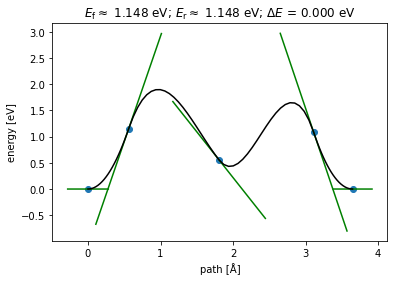

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.0719          4.9959        2.5716     +  0.1982


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2430          1.3538        0.0643     +  0.2490
      3          0.0561          1.1349        0.0266     +  0.3019
      4          0.0350          0.9840        0.0194     +  0.3150
      5          0.0232          0.5771        0.0067     +  0.1811
      6          0.0091          0.4411        0.0038     +  0.1834
      7          0.0047          0.3480        0.0024     +  0.2029
      8          0.0039          0.2802        0.0015     +  0.2161
      9          0.0031          0.2376        0.0011     +  0.2182
     10          0.0026          0.2107        0.0009     +  0.1870
     11          0.0023          0.1940        0.0007     +  0.1889
     12          0.0021          0.1872        0.0007     +  0.1898
     13          0.0021          0.1872        0.0007     +  0.1958
     14          0.0008          0.1320        0.0003     +  0.1850
     15          0.0019          0.1202        0.0003     +  0.1844
     16          0.0028          0.1087        0

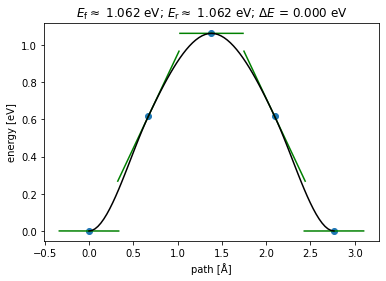

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.8880          4.4611        4.3832     +  0.1653


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3067          1.7319        0.2152     +  0.1866
      3          0.0541          1.3189        0.0729     +  0.3322
      4          0.0591          1.0099        0.0445     +  0.4073
      5          0.0415          0.5949        0.0160     +  0.2169
      6          0.0213          0.3759        0.0061     +  0.3254
      7          0.0123          0.3110        0.0040     +  0.3488
      8          0.0085          0.2761        0.0031     +  0.2194
      9          0.0071          0.2429        0.0024     +  0.2285
     10          0.0064          0.2095        0.0018     +  0.2516
     11          0.0059          0.1966        0.0016     +  0.2406
     12          0.0057          0.1928        0.0015     +  0.2320
     13          0.0057          0.1928        0.0015     +  0.2171
     14          0.0024          0.1240        0.0006     +  0.2247
     15          0.0030          0.1080        0.0005     +  0.2184
     16          0.0039          0.0965        0

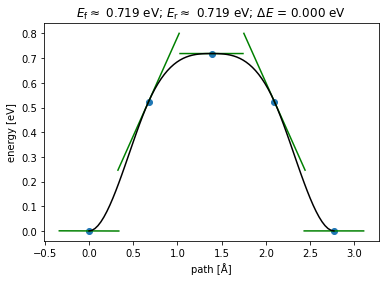

Terminating! Convergence criteria has been met


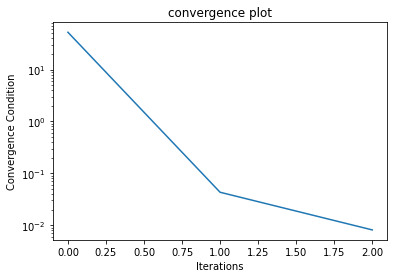

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.9009   652481.4375     +  0.0900
      2          0.0005          3.7579   605531.4375     +  0.0950


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0005          3.7133   591235.4375     +  0.0920
      4          0.0006          3.6386   567682.1250     +  0.0934
      5          0.0007          3.4965   524205.8750     +  0.1002
      6          0.0028          3.8717   642768.3125        0.1099
      7          0.0028          3.5957   554401.4375        0.1516
      8          0.0028          3.4536   511437.9062     +  0.1465
      9          0.0029          3.3469   480334.1250     +  0.1463
     10          0.0028          3.2917   464624.4375     +  0.1494
     11          0.0028          3.2743   459703.1250     +  0.1478
     12          0.0027          3.2661   457408.8125     +  0.0596
     13          0.0027          3.2661   457406.9062     +  0.1562
     14          0.0022          3.2294   447193.7500     +  0.1465
     15          0.0022          3.2223   445236.4688     +  0.1476
     16          0.0025          3.2063   440823.7188     +  0.1519
     17          0.0024          3.1967   438179

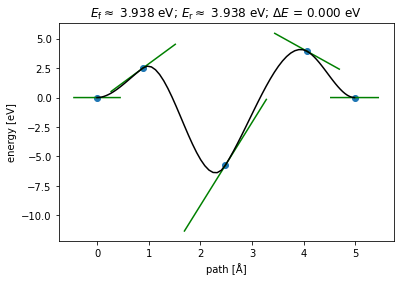

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.1191          5.1718        2.6091     +  0.1314
      2          0.2573          1.7657        0.0896     +  0.1447


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0739          1.2037        0.0298     +  0.1634
      4          0.0602          1.0017        0.0205     +  0.1740
      5          0.0358          0.6108        0.0076     +  0.4129
      6          0.0142          0.4205        0.0034     +  0.4026
      7          0.0081          0.3344        0.0021     +  0.1803
      8          0.0065          0.2958        0.0017     +  0.2613
      9          0.0056          0.2685        0.0014     +  0.3623
     10          0.0051          0.2495        0.0012     +  0.2222
     11          0.0048          0.2400        0.0011     +  0.1965
     12          0.0047          0.2368        0.0011     +  0.0295
     13          0.0047          0.2368        0.0011     +  0.2051
     14          0.0046          0.1774        0.0006     +  0.1867
     15          0.0057          0.1559        0.0005     +  0.2035
     16          0.0064          0.1399        0.0004     +  0.1808
     17          0.0062          0.1210        0

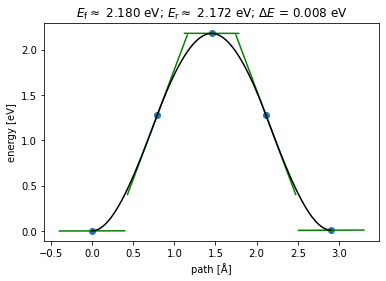

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.8605          4.8508        4.5749     +  0.1682


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2108          1.3932        0.1268     +  0.1878
      3          0.0578          1.0661        0.0507     +  0.1959
      4          0.0660          0.8310        0.0332     +  0.2247
      5          0.0362          0.5015        0.0118     +  0.2428
      6          0.0178          0.3989        0.0069     +  0.2388
      7          0.0095          0.3451        0.0050     +  0.2154
      8          0.0090          0.3116        0.0041     +  0.2213
      9          0.0093          0.2841        0.0034     +  0.2403
     10          0.0078          0.2525        0.0027     +  0.2233
     11          0.0067          0.2400        0.0024     +  0.4835
     12          0.0064          0.2362        0.0024     +  0.3671
     13          0.0064          0.2362        0.0024     +  0.2318
     14          0.0034          0.1807        0.0014     +  0.3113
     15          0.0043          0.1631        0.0011     +  0.4279
     16          0.0042          0.1471        0

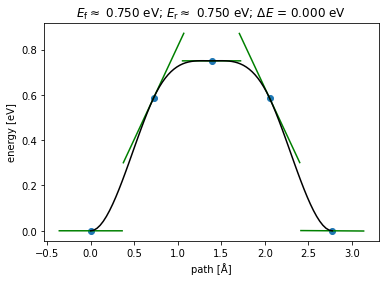

Terminating! Convergence criteria has been met


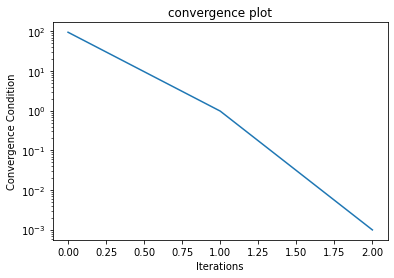

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.8985   651681.7500     +  0.0893


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.0003          3.8195   625555.3750     +  0.1142
      3          0.0013          3.3930   493630.0625     +  0.3251
      4          0.0019          3.2322   447957.4688     +  0.2804
      5          0.0020          3.2237   445600.7812     +  0.1503
      6          0.0020          3.2178   443980.4688     +  0.1405
      7          0.0020          3.2101   441873.3438     +  0.1481
      8          0.0020          3.2091   441595.2188     +  0.2305
      9          0.0020          3.2088   441508.5000     +  0.1567
     10          0.0020          3.2086   441454.6875     +  0.1618
     11          0.0020          3.2085   441413.5625     +  0.1483
     12          0.0020          3.2084   441395.4688     +  0.0438
     13          0.0020          3.2084   441395.4688        0.1446
     14          0.0016          3.2216   445028.8750        0.1426
     15          0.0017          3.2058   440675.7500     +  0.1620
     16          0.0017          3.2014   439470

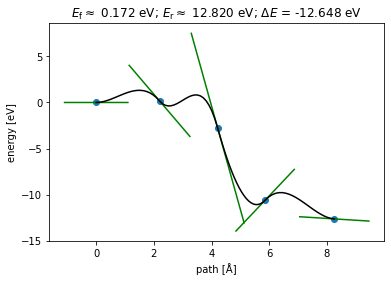

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.1784          4.8229        2.5678     +  0.1282
      2          0.2451          1.5968        0.0733     +  0.1650


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0582          1.3670        0.0353     +  0.1712
      4          0.0408          1.2148        0.0275     +  0.1627
      5          0.0432          0.7564        0.0112     +  0.1935
      6          0.0261          0.7009        0.0092     +  0.1785
      7          0.0202          0.5785        0.0062     +  0.1746
      8          0.0123          0.4618        0.0039     +  0.1907
      9          0.0092          0.3758        0.0026     +  0.1878
     10          0.0084          0.3274        0.0020     +  0.1819
     11          0.0081          0.3011        0.0017     +  0.1835
     12          0.0079          0.2914        0.0016     +  0.2200
     13          0.0079          0.2914        0.0016     +  0.1791
     14          0.0051          0.1784        0.0006     +  0.1809
     15          0.0037          0.1558        0.0004     +  0.1842
     16          0.0023          0.1356        0.0003     +  0.1801
     17          0.0012          0.1202        0

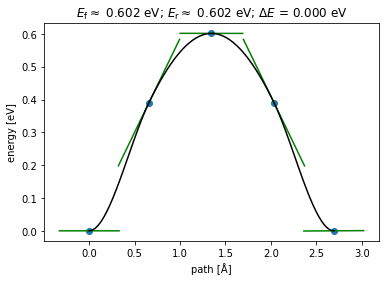

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.9522          4.6458        4.2967     +  0.1844


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3150          1.4304        0.1665     +  0.1919
      3          0.0790          1.1560        0.0549     +  0.1866
      4          0.0278          1.0143        0.0385     +  0.2132
      5          0.0467          0.6431        0.0172     +  0.2217
      6          0.0359          0.4783        0.0096     +  0.2281
      7          0.0186          0.3486        0.0048     +  0.2135
      8          0.0130          0.2998        0.0035     +  0.2302
      9          0.0109          0.2713        0.0028     +  0.2146
     10          0.0097          0.2525        0.0024     +  0.2131
     11          0.0088          0.2409        0.0022     +  0.2150
     12          0.0084          0.2365        0.0021     +  0.2204
     13          0.0084          0.2365        0.0021     +  0.3847
     14          0.0042          0.1627        0.0010     +  0.2533
     15          0.0043          0.1420        0.0008     +  0.2244
     16          0.0049          0.1315        0

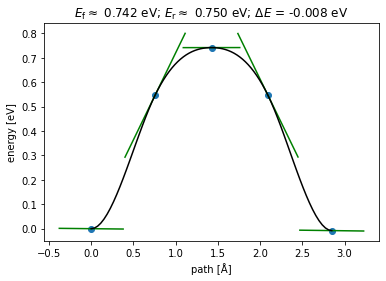

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.8801          4.8991        7.3342     +  0.4161


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3619          1.5539        0.3713     +  0.4466
      3          0.0890          1.1671        0.1018     +  0.3586
      4          0.0298          0.9128        0.0558     +  0.2747
      5          0.0243          0.5467        0.0205     +  0.2594
      6          0.0143          0.3487        0.0083     +  0.2840
      7          0.0096          0.2872        0.0055     +  0.2865
      8          0.0065          0.2440        0.0040     +  0.2987
      9          0.0043          0.2096        0.0029     +  0.2517
     10          0.0031          0.1906        0.0024     +  0.2663
     11          0.0027          0.1786        0.0021     +  0.2503
     12          0.0025          0.1743        0.0020     +  0.0743
     13          0.0025          0.1743        0.0020     +  0.2523
     14          0.0028          0.1188        0.0009     +  0.2781
     15          0.0028          0.1098        0.0008     +  0.2646
     16          0.0025          0.0965        0

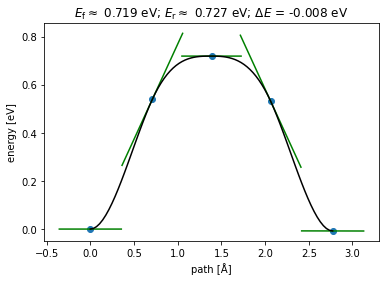

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.6214          4.5611        8.7952     +  0.4227


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3401          1.4671        0.5126     +  0.3926
      3          0.0876          1.1232        0.1477     +  0.2987
      4          0.0284          0.8069        0.0682     +  0.5028
      5          0.0244          0.4947        0.0264     +  0.3624
      6          0.0197          0.3578        0.0140     +  0.3082
      7          0.0155          0.2868        0.0090     +  0.3210
      8          0.0107          0.2424        0.0063     +  0.3326
      9          0.0077          0.2181        0.0050     +  0.3059
     10          0.0061          0.2043        0.0043     +  0.2921
     11          0.0055          0.1967        0.0040     +  0.2984
     12          0.0053          0.1939        0.0039     +  0.2840
     13          0.0053          0.1939        0.0039     +  0.2997
     14          0.0030          0.1275        0.0017     +  0.2992
     15          0.0026          0.1039        0.0011     +  0.3106
     16          0.0023          0.0906        0

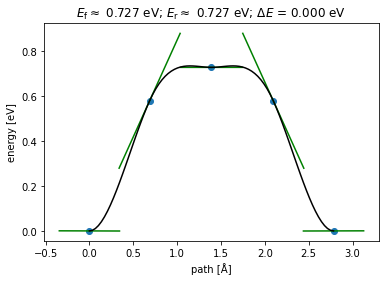

Terminating! Convergence criteria has been met


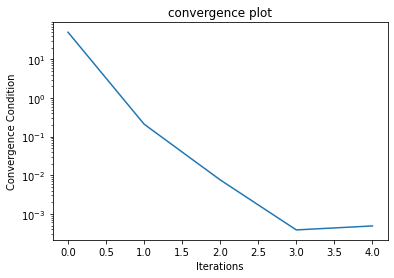

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.9013   652631.8125     +  0.0916
      2          0.0007          3.7343   597955.3750     +  0.0922


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0235          8.2888  2946551.0000        0.1153
      4          0.0262          4.4590   853298.5000        0.1157
      5          0.0277          3.5792   550117.6875     +  0.1299
      6          0.0282          3.4482   510672.2812     +  0.1424
      7          0.0283          3.4225   503116.8750     +  0.1420
      8          0.0284          3.4145   500795.7500     +  0.2909
      9          0.0284          3.4095   499304.8438     +  0.1686
     10          0.0281          3.3972   495709.5625     +  0.1508
     11          0.0272          3.3709   488026.0938     +  0.2518
     12          0.0271          3.3658   486533.0625     +  0.1144
     13          0.0271          3.3658   486532.6250     +  0.2968
     14          0.0179         11.3245  5499355.0000        0.1546
     15          0.0217          6.4292  1772895.7500        0.1446
     16          0.0238          4.5935   905365.7500        0.1499
     17          0.0256          3.7082   590328

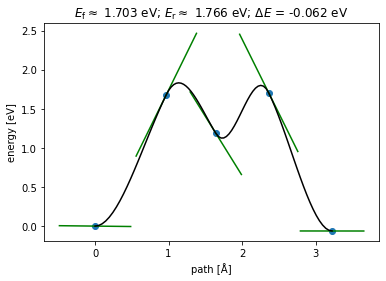

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.2644          5.4570        3.0321     +  0.2744


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2635          1.9843        0.1089     +  0.2833
      3          0.0469          1.5382        0.0465     +  0.1591
      4          0.0735          1.0516        0.0238     +  0.1699
      5          0.0434          0.6008        0.0078     +  0.1952
      6          0.0143          0.3951        0.0031     +  0.1971
      7          0.0063          0.3116        0.0019     +  0.2002
      8          0.0053          0.2677        0.0014     +  0.1901
      9          0.0049          0.2278        0.0010     +  0.1838
     10          0.0047          0.2061        0.0008     +  0.1785
     11          0.0045          0.1962        0.0007     +  0.1949
     12          0.0045          0.1929        0.0007     +  0.0209
     13          0.0045          0.1929        0.0007     +  0.2090
     14          0.0035          0.1297        0.0003     +  0.1776
     15          0.0029          0.1170        0.0003     +  0.1780
     16          0.0024          0.1092        0

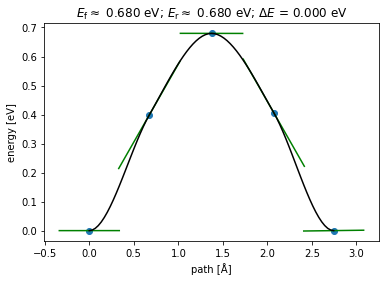

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.9616          4.7372        4.6922     +  0.1769


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2793          1.3871        0.1532     +  0.1744
      3          0.0786          1.0981        0.0538     +  0.1899
      4          0.0575          0.9342        0.0378     +  0.1998
      5          0.0500          0.5643        0.0151     +  0.2105
      6          0.0249          0.4445        0.0084     +  0.3575
      7          0.0121          0.3660        0.0054     +  0.2411
      8          0.0096          0.3224        0.0042     +  0.2278
      9          0.0100          0.2910        0.0034     +  0.3224
     10          0.0099          0.2587        0.0027     +  0.3185
     11          0.0095          0.2405        0.0024     +  0.4145
     12          0.0092          0.2349        0.0023     +  0.2170
     13          0.0092          0.2349        0.0023     +  0.2330
     14          0.0061          0.1795        0.0013     +  0.2167
     15          0.0037          0.1591        0.0010     +  0.2488
     16          0.0047          0.1454        0

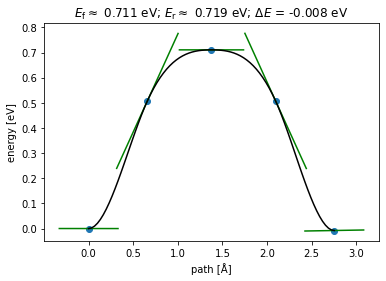

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.7515          4.6481        6.7803     +  0.2123


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3121          1.5412        0.3318     +  0.2398
      3          0.0670          1.1297        0.0958     +  0.2237
      4          0.0499          0.8019        0.0487     +  0.4258
      5          0.0325          0.4334        0.0148     +  0.4795
      6          0.0184          0.3419        0.0086     +  0.2657
      7          0.0119          0.2955        0.0063     +  0.2688
      8          0.0079          0.2630        0.0049     +  0.2711
      9          0.0054          0.2183        0.0033     +  0.3016
     10          0.0042          0.1976        0.0027     +  0.2691
     11          0.0035          0.1874        0.0024     +  0.2626
     12          0.0034          0.1846        0.0024     +  0.1106
     13          0.0034          0.1846        0.0024     +  0.2678
     14          0.0027          0.1401        0.0014     +  0.2703
     15          0.0034          0.1205        0.0010     +  0.2697
     16          0.0023          0.1015        0

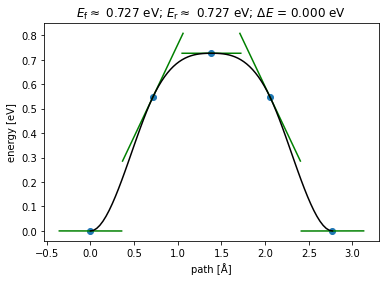

Terminating! Convergence criteria has been met


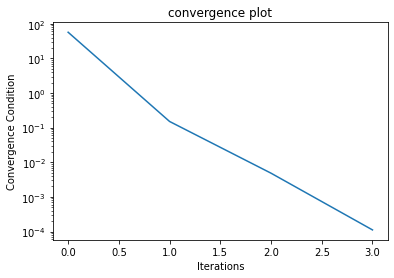

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0007          3.9049   653830.6250     +  0.0915


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.0008          3.7238   594601.1250     +  0.1033
      3          0.0006          3.5980   555091.1875     +  0.1015
      4          0.0005          3.2579   455121.2188     +  0.1059
      5          0.0005          3.2175   443896.0625     +  0.1171
      6          0.0005          3.2076   441168.3750     +  0.1308
      7          0.0006          3.2051   440483.4375     +  0.1406
      8          0.0007          3.2024   439730.4375     +  0.1615
      9          0.0010          3.1934   437267.9062     +  0.1476
     10          0.0017          3.1717   431355.7500     +  0.1569
     11          0.0018          3.1629   428951.1250     +  0.1449
     12          0.0019          3.1593   427987.5000     +  0.1617
     13          0.0019          3.1593   427983.9375     +  0.1510
     14          0.0018          3.1085   414333.2500     +  0.1498
     15          0.0160          4.2443   772714.5625        0.1441
     16          0.0065          3.3141   470998

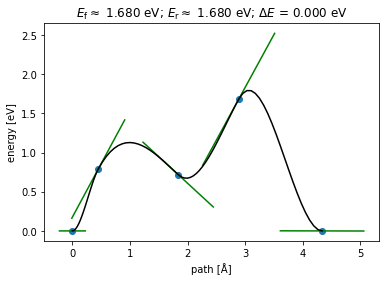

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.1556          5.0201        2.4780     +  0.1500
      2          0.2461          1.6268        0.0729     +  0.1521


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0536          1.3893        0.0351     +  0.1801
      4          0.0564          1.2094        0.0270     +  0.2501
      5          0.0372          0.6497        0.0080     +  0.2938
      6          0.0085          0.5431        0.0052     +  0.2122
      7          0.0124          0.4338        0.0034     +  0.1921
      8          0.0146          0.3543        0.0023     +  0.3621
      9          0.0117          0.3068        0.0017     +  0.3288
     10          0.0090          0.2720        0.0013     +  0.1917
     11          0.0080          0.2567        0.0012     +  0.2006
     12          0.0077          0.2520        0.0011     +  0.0329
     13          0.0077          0.2520        0.0011     +  0.2151
     14          0.0045          0.1754        0.0005     +  0.2103
     15          0.0042          0.1500        0.0004     +  0.1967
     16          0.0024          0.1246        0.0003     +  0.2120
     17          0.0011          0.1082        0

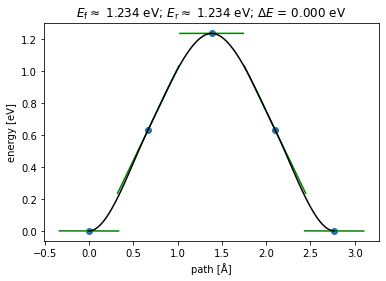

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.9239          4.6382        4.1737     +  0.1947


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2954          1.3897        0.1505     +  0.1778
      3          0.0790          1.0672        0.0474     +  0.2069
      4          0.0542          0.9046        0.0326     +  0.2072
      5          0.0493          0.6228        0.0164     +  0.3042
      6          0.0205          0.4191        0.0068     +  0.4988
      7          0.0119          0.3179        0.0038     +  0.2322
      8          0.0097          0.2803        0.0030     +  0.2241
      9          0.0087          0.2528        0.0024     +  0.2357
     10          0.0080          0.2288        0.0020     +  0.3098
     11          0.0076          0.2139        0.0017     +  0.2486
     12          0.0074          0.2085        0.0016     +  0.2487
     13          0.0074          0.2085        0.0016     +  0.2224
     14          0.0038          0.1392        0.0007     +  0.2173
     15          0.0031          0.1230        0.0006     +  0.2349
     16          0.0033          0.1136        0

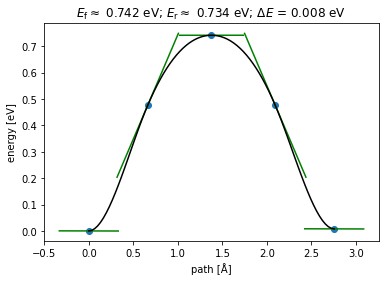

Terminating! Convergence criteria has been met


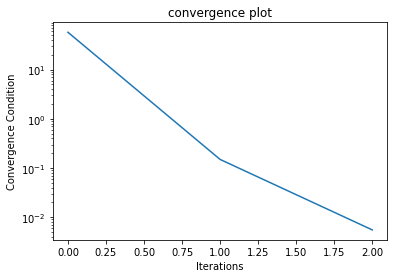

In [9]:
force_calls = []
#Here we run the code 5 times to ensure consistency of the results, for testing changing the 5 to a 1 is sufficient to run a full Active learning calculation to build the NEB
for i in range(5):
  os.mkdir(f'NEB_iter_{i}')
  os.chdir(f'NEB_iter_{i}')
  # Define symmetry functions
  Gs = {}
  Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
  Gs["G2_rs_s"] = [0] * 4
  Gs["G4_etas"] = [0.005]
  Gs["G4_zetas"] = [1.0, 4.0]
  Gs["G4_gammas"] = [+1.0, -1]
  Gs["cutoff"] = 6.0

  # Training parameters for the active learning framework
  training_params = {
        "al_convergence": {"method": "neb_iter", "num_iterations": 7,"energy_tol":0.01},
        "samples_to_retrain": 1,
        "Gs": Gs,
        "morse": True,
        "forcetraining": True,
        "cores": 1,
        "optimizer": torch.optim.LBFGS,
        "batch_size": 1000,
        "criterion": CustomMSELoss,
        "num_layers": 3,
        "num_nodes": 20,
        "force_coefficient": 0.04,
        "learning_rate": 1e-2,
        "epochs": 200,
        "test_split": 0,
        "shuffle": False,
        "verbose": 1,
        "filename": "neb_ml_only_ml2relax_True",
        "file_dir": "./",
        "scheduler": {"policy": "CosineAnnealingWarmRestarts", "params":{"T_0":10, "T_mult":2}}
    }

  ml2relax = True #use machine learning to relax the initial and final states rather than DFT as is the norm
  
  parent_calc = Espresso(pw=500.0, 
                  calculation='scf',
                  kpts=(4,4,1),
                  xc='PBE')
  
  initial, final, initial_force_calls = construct_geometries(parent_calc=parent_calc, ml2relax=ml2relax)
  images = [initial]
  images.append(final)

  # Define AL scheme

  learner = AtomisticActiveLearner(
      training_data=images,
      training_params=training_params,
      parent_calc=parent_calc,
      ensemble=False
  )

  # Learn the corresponding atomistic method
  total_neb_images = 5  # N + 2 where N is the number of intermediate images and 2 is for initial and final structures

  learner.learn(
      atomistic_method=NEBcalc(
          starting_images=images, 
          ml2relax=ml2relax, 
          intermediate_samples=total_neb_images-2), 
      query_strategy=random_query
    )
  force_calls.append(initial_force_calls+learner.parent_calls)
  os.chdir('/content/drive/My Drive/Colab Notebooks/NEB/new_dft_runs')

In [10]:
print('The DFT calls for each run of the active-learning framework is:',force_calls)

The DFT calls for each run of the active-learning framework is: [11, 11, 17, 14, 11]


In [11]:
(force_calls[0]+force_calls[1]+force_calls[2]+force_calls[3]+force_calls[4])/5

12.8

Visualize AL Results

In [12]:
def neb_analysis(images, label, ax=None):
  nebtools = NEBTools(images)
  barrier, dE = nebtools.get_barrier()
  max_force = nebtools.get_fmax()
  fig = nebtools.plot_band(ax=ax)
  fig.savefig(label+'.png', dpi=300)
  return barrier, dE,max_force

#### Code to generate true NEB

The following code is meant to be run seperately in order to identify the NEB that is built purely using DFT

In [13]:
parent_calc = Espresso(pw=500.0, 
                  calculation='scf',
                  kpts=(4,4,1),
                  xc='PBE')
ml2relax = True
initial, final, initial_force_calls = construct_geometries(parent_calc=parent_calc, ml2relax=ml2relax)
total_neb_images = 5


In [14]:
dft_counter = CounterCalc(Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE'),"DFT_database1")
if not ml2relax:
  # Load previously computed relaxed states
  initial_slab1 = read("initial.traj", "-1")
  final_slab1 = read("final.traj", "-1")
else:
  initial.set_calculator(dft_counter)
  final.set_calculator(dft_counter)
  qn = BFGS(initial, trajectory='original_parent_initial.traj', logfile='original_initial_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  qn = BFGS(final, trajectory='original_parent_final.traj', logfile='original_final_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  initial_slab1 = read("original_parent_initial.traj", "-1")
  final_slab1 = read("original_parent_final.traj", "-1")

images2 = [initial_slab1]
for i in range(total_neb_images - 2):
    image = final_slab1.copy()
    image.set_calculator(dft_counter)
    images2.append(image)
images2.append(final_slab1)

neb = SingleCalculatorNEB(images2)
neb.interpolate()
qn = BFGS(neb, trajectory='actual_neb1.traj')
qn.run(fmax=0.01,steps = 100)

      Step     Time          Energy         fmax
BFGS:    0 15:43:07   -66355.611084       11.9354
BFGS:    1 15:46:12   -66357.907954        2.2174
BFGS:    2 15:49:24   -66357.947721        1.0338
BFGS:    3 15:52:28   -66358.001367        0.7759
BFGS:    4 15:55:39   -66358.056930        0.7162
BFGS:    5 15:58:46   -66358.108125        0.7939
BFGS:    6 16:01:52   -66358.125509        0.5920
BFGS:    7 16:05:03   -66358.128558        0.3692
BFGS:    8 16:08:14   -66358.134617        0.3334
BFGS:    9 16:11:30   -66358.141790        0.2537
BFGS:   10 16:14:41   -66358.151593        0.2403
BFGS:   11 16:17:59   -66358.155225        0.1798
BFGS:   12 16:21:10   -66358.156063        0.1555
BFGS:   13 16:24:19   -66358.156712        0.0854
BFGS:   14 16:27:25   -66358.156825        0.0563
BFGS:   15 16:30:35   -66358.156700        0.0620
BFGS:   16 16:33:46   -66358.156634        0.0593
BFGS:   17 16:36:56   -66358.156674        0.0277
BFGS:   18 16:40:06   -66358.156715        0.0245
B

True

Ef = 0.7302062512317207, dE = 0.0005457243387354538, force = 0.007643291492705531
Total number of force calls = 163


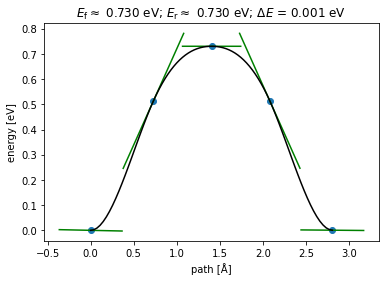

In [15]:
images = read(f'actual_neb1.traj@-{total_neb_images}:')
nebtools = NEBTools(images)

Ef, dE,force = neb_analysis(images, label="actual_neb")

print(f"Ef = {Ef}, dE = {dE}, force = {force}")
print(f"Total number of force calls = {initial_force_calls+dft_counter.force_calls}")